**Primeira Etapa**

Escolha uma série de CPI:
1. All items
2. All items less food and energy
3. Apparel
4. Education and communication
5. Energy
6. Food
7. Medical care
8. Other goods and services
9. Recreation
10. Transportation
Digite o número da sua escolha (1-10): 10
         Jan     Feb     Mar     Apr     May     Jun     Jul     Aug     Sep     Oct     Nov     Dec  Annual   HALF1   HALF2
Year                                                                                                                        
2010  193.12  191.98  191.38  191.25  190.23  189.43  191.08  192.29  193.32  196.84  198.78  202.45  193.51  191.23  195.79
2011  204.23  205.70  209.59  213.03  214.50  212.96  213.66  214.65  215.46  214.68  215.15  213.78  212.28  210.00  214.56
2012  215.38  217.69  218.46  218.62  215.03  212.22  211.79  217.57  221.57  222.91  218.83  217.52  217.30  216.23  218.37
2013  218.09  223.27  218.98  214.90  214.01  215.38  216.56  217.90  216.90  216.68  217.17  218.72  217.38  217.44  217.3

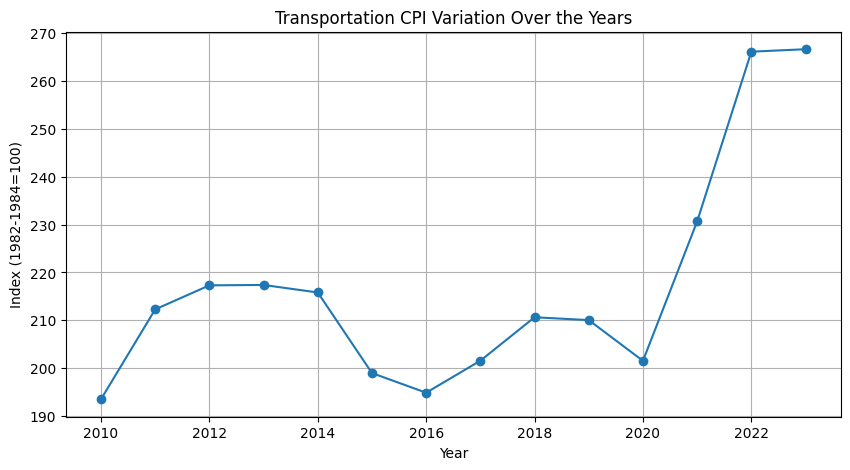

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import requests
import calendar
import matplotlib.pyplot as plt
from google.colab import files


# Configurações do Pandas para exibir todas as colunas na mesma linha
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)  # Ajuste este valor conforme necessário

# API Key fornecida
api_key = 'da5fc38751f14e008c943a04d477f254'

# Função para carregar dados da API
def load_cpi_data():
    cpi_series = {
        "CUSR0000SA0": "All items",
        "CUSR0000SA0L1E": "All items less food and energy",
        "CUSR0000SAF1": "Food",
        "CUSR0000SA0E": "Energy",
        "CUSR0000SAA": "Apparel",
        "CUSR0000SAE": "Education and communication",
        "CUSR0000SAG": "Other goods and services",
        "CUSR0000SAM": "Medical care",
        "CUSR0000SAR": "Recreation",
        "CUSR0000SAT": "Transportation"
    }

    cpi_data = pd.DataFrame()
    url = "https://api.bls.gov/publicAPI/v2/timeseries/data/"

    for series_id, series_name in cpi_series.items():
        payload = {
            "seriesid": [series_id],
            "startyear": "2010",
            "endyear": "2023",
            "registrationkey": api_key
        }

        response = requests.post(url, json=payload)

        if response.status_code == 200:
            json_data = response.json()

            if json_data['status'] == 'REQUEST_SUCCEEDED':
                series_data = json_data['Results']['series'][0]['data']
                series_df = pd.DataFrame(series_data)
                series_df['series_name'] = series_name  # Adicionando o nome da série
                cpi_data = pd.concat([cpi_data, series_df], ignore_index=True)
            else:
                print(f"Erro ao obter dados da série {series_name}: {json_data['message']}")
        else:
            print(f"Erro na requisição HTTP: {response.status_code}")

    # Verificando se as colunas 'year' e 'period' estão presentes
    if 'year' not in cpi_data.columns or 'period' not in cpi_data.columns:
        raise ValueError("Colunas 'year' ou 'period' não encontradas nos dados da API")

    cpi_data['date'] = pd.to_datetime(cpi_data['year'] + cpi_data['period'], format='%YM%m')
    cpi_data.drop(['year', 'period'], axis=1, inplace=True)
    cpi_data['value'] = cpi_data['value'].astype(float)

    return cpi_data

# Função para transformar dados em formato de tabela mensal
def transform_data_to_monthly_table(selected_data):
    selected_data['Year'] = selected_data['date'].dt.year
    selected_data['Month'] = selected_data['date'].dt.month

    # Pivotando os dados para obter os valores mensais em colunas separadas
    pivot_table = selected_data.pivot_table(index='Year', columns='Month', values='value', aggfunc='mean')

    # Renomeando as colunas para os nomes dos meses
    month_names = {i: calendar.month_abbr[i] for i in range(1, 13)}
    pivot_table.rename(columns=month_names, inplace=True)

    # Removendo o nome 'Month' do cabeçalho das colunas
    pivot_table.columns.name = None

    # Calculando as médias anuais e semestrais
    pivot_table['Annual'] = pivot_table.mean(axis=1)
    pivot_table['HALF1'] = pivot_table[['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun']].mean(axis=1)
    pivot_table['HALF2'] = pivot_table[['Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']].mean(axis=1)

    # Arredondando todas as colunas para duas casas decimais
    pivot_table = pivot_table.round(2)

    # Substituindo NaN por vazios
    pivot_table = pivot_table.fillna('')

    return pivot_table

# Função para plotar o gráfico da série CPI selecionada
def plot_cpi_graph(yearly_data, series_title):
    plt.figure(figsize=(10, 5))
    plt.plot(yearly_data['Annual'], marker='o')
    plt.title(f'{series_title} CPI Variation Over the Years')
    plt.xlabel('Year')
    plt.ylabel('Index (1982-1984=100)')
    plt.grid(True)
    plt.show()
# Função para salvar o DataFrame em um arquivo Excel com nome personalizado
def save_to_excel(pivot_table, series_name):
    excel_filename = f"{series_name}_relatorioCPI.xlsx"
    pivot_table.to_excel(excel_filename, index=True)
    files.download(excel_filename)

# Função principal
def main():
    cpi_data = load_cpi_data()
    series_dict = {series_name: df for series_name, df in cpi_data.groupby('series_name')}

    # Exibindo as opções para o usuário
    print("Escolha uma série de CPI:")
    for i, series_name in enumerate(series_dict.keys(), start=1):
        print(f"{i}. {series_name}")

    # Solicitando a escolha do usuário
    choice = int(input("Digite o número da sua escolha (1-10): "))
    series_name = list(series_dict.keys())[choice - 1]

    if series_name in series_dict:
        selected_data = series_dict[series_name]
        monthly_table = transform_data_to_monthly_table(selected_data)
        print(monthly_table)

        # Plotando o gráfico para a série selecionada com o título correspondente
        plot_cpi_graph(monthly_table, series_name)

        # Exportando diretamente para o Excel
        save_to_excel(monthly_table, series_name)
    else:
        print("Escolha inválida.")

if __name__ == "__main__":
    main()


Escolha uma série de CPI:
1. All items
2. All items less food and energy
3. Apparel
4. Education and communication
5. Energy
6. Food
7. Medical care
8. Other goods and services
9. Recreation
10. Transportation
Digite o número da sua escolha (1-10): 9
         Jan     Feb     Mar     Apr     May     Jun     Jul     Aug     Sep     Oct     Nov     Dec  Annual   HALF1   HALF2
Year                                                                                                                        
2010  113.57  113.34  113.20  113.54  113.48  113.64  113.58  113.47  113.08  113.09  113.11  112.72  113.32  113.46  113.18
2011  112.89  113.16  113.10  113.12  113.44  113.48  113.35  113.55  113.45  113.39   113.5   113.9  113.36  113.20  113.52
2012  114.49  114.30  114.52  114.40  114.39  114.78  114.66  114.83  115.01  114.96  115.16  114.97  114.71  114.48  114.93
2013  115.08  115.28  115.19  115.06  115.27  115.12  115.12  115.27  115.30  115.42  115.74  115.39  115.27  115.17  115.37

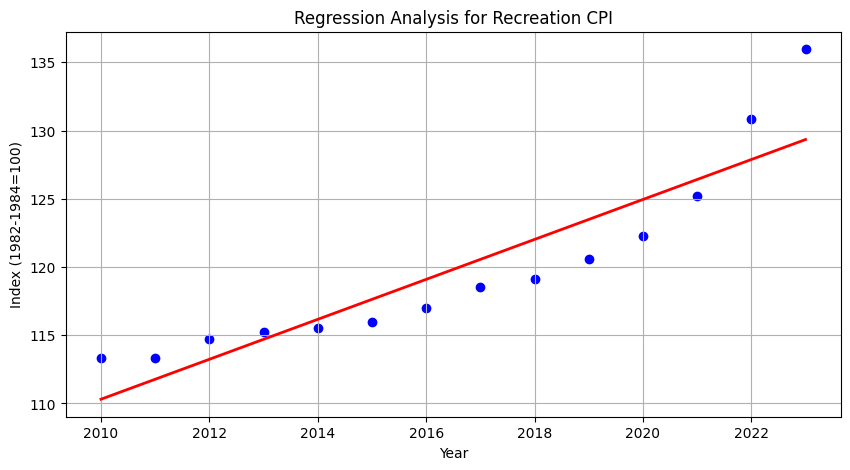

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import requests
import calendar
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from google.colab import files


# Configurações do Pandas para exibir todas as colunas na mesma linha
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)  # Ajuste este valor conforme necessário

# API Key fornecida
api_key = 'da5fc38751f14e008c943a04d477f254'

# Função para carregar dados da API
def load_cpi_data():
    cpi_series = {
        "CUSR0000SA0": "All items",
        "CUSR0000SA0L1E": "All items less food and energy",
        "CUSR0000SAF1": "Food",
        "CUSR0000SA0E": "Energy",
        "CUSR0000SAA": "Apparel",
        "CUSR0000SAE": "Education and communication",
        "CUSR0000SAG": "Other goods and services",
        "CUSR0000SAM": "Medical care",
        "CUSR0000SAR": "Recreation",
        "CUSR0000SAT": "Transportation"
    }

    cpi_data = pd.DataFrame()
    url = "https://api.bls.gov/publicAPI/v2/timeseries/data/"

    for series_id, series_name in cpi_series.items():
        payload = {
            "seriesid": [series_id],
            "startyear": "2010",
            "endyear": "2023",
            "registrationkey": api_key
        }

        response = requests.post(url, json=payload)

        if response.status_code == 200:
            json_data = response.json()

            if json_data['status'] == 'REQUEST_SUCCEEDED':
                series_data = json_data['Results']['series'][0]['data']
                series_df = pd.DataFrame(series_data)
                series_df['series_name'] = series_name  # Adicionando o nome da série
                cpi_data = pd.concat([cpi_data, series_df], ignore_index=True)
            else:
                print(f"Erro ao obter dados da série {series_name}: {json_data['message']}")
        else:
            print(f"Erro na requisição HTTP: {response.status_code}")

    # Verificando se as colunas 'year' e 'period' estão presentes
    if 'year' not in cpi_data.columns or 'period' not in cpi_data.columns:
        raise ValueError("Colunas 'year' ou 'period' não encontradas nos dados da API")

    cpi_data['date'] = pd.to_datetime(cpi_data['year'] + cpi_data['period'], format='%YM%m')
    cpi_data.drop(['year', 'period'], axis=1, inplace=True)
    cpi_data['value'] = cpi_data['value'].astype(float)

    return cpi_data

# Função para transformar dados em formato de tabela mensal
def transform_data_to_monthly_table(selected_data):
    selected_data['Year'] = selected_data['date'].dt.year
    selected_data['Month'] = selected_data['date'].dt.month

    # Pivotando os dados para obter os valores mensais em colunas separadas
    pivot_table = selected_data.pivot_table(index='Year', columns='Month', values='value', aggfunc='mean')

    # Renomeando as colunas para os nomes dos meses
    month_names = {i: calendar.month_abbr[i] for i in range(1, 13)}
    pivot_table.rename(columns=month_names, inplace=True)

    # Removendo o nome 'Month' do cabeçalho das colunas
    pivot_table.columns.name = None

    # Calculando as médias anuais e semestrais
    pivot_table['Annual'] = pivot_table.mean(axis=1)
    pivot_table['HALF1'] = pivot_table[['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun']].mean(axis=1)
    pivot_table['HALF2'] = pivot_table[['Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']].mean(axis=1)

    # Arredondando todas as colunas para duas casas decimais
    pivot_table = pivot_table.round(2)

    # Substituindo NaN por vazios
    pivot_table = pivot_table.fillna('')

    return pivot_table



# Função para plotar o gráfico da série CPI selecionada
def plot_cpi_graph(yearly_data, series_title):
    plt.figure(figsize=(10, 5))
    plt.plot(yearly_data['Annual'], marker='o')
    plt.title(f'{series_title} CPI Variation Over the Years')
    plt.xlabel('Year')
    plt.ylabel('Index (1982-1984=100)')
    plt.grid(True)
    plt.show()

# Função para realizar e plotar a regressão linear
def plot_regression_graph(yearly_data, series_title):
    # Preparando os dados para a regressão linear
    X = yearly_data.index.values.reshape(-1, 1)  # Anos
    y = yearly_data['Annual'].values.reshape(-1, 1)  # Valores CPI

    # Criando e treinando o modelo de regressão linear
    model = LinearRegression()
    model.fit(X, y)

    # Previsão do modelo
    y_pred = model.predict(X)

    # Plotando o gráfico de regressão
    plt.figure(figsize=(10, 5))
    plt.scatter(X, y, color='blue')
    plt.plot(X, y_pred, color='red', linewidth=2)
    plt.title(f'Regression Analysis for {series_title} CPI')
    plt.xlabel('Year')
    plt.ylabel('Index (1982-1984=100)')
    plt.grid(True)
    plt.show()

# Função para salvar o DataFrame em um arquivo Excel com nome personalizado
def save_to_excel(pivot_table, series_name):
    excel_filename = f"{series_name}_relatorioCPI.xlsx"
    pivot_table.to_excel(excel_filename, index=True)
    files.download(excel_filename)

# Função principal
def main():
    cpi_data = load_cpi_data()
    series_dict = {series_name: df for series_name, df in cpi_data.groupby('series_name')}

    # Exibindo as opções para o usuário
    print("Escolha uma série de CPI:")
    for i, series_name in enumerate(series_dict.keys(), start=1):
        print(f"{i}. {series_name}")

    # Solicitando a escolha do usuário
    choice = int(input("Digite o número da sua escolha (1-10): "))
    series_name = list(series_dict.keys())[choice - 1]

    if series_name in series_dict:
        selected_data = series_dict[series_name]
        monthly_table = transform_data_to_monthly_table(selected_data)
        print(monthly_table)

              # Plotando o gráfico de regressão linear para a série selecionada
        plot_regression_graph(monthly_table, series_name)

        # Exportando para o Excel
        save_to_excel(monthly_table, series_name)

    else:
        print("Escolha inválida.")

if __name__ == "__main__":
    main()


**Segunda Etapa**

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from google.colab import files  # Importando a função necessária para download

url = "https://www.bls.gov/news.release/cpi.htm"

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3',
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
    'Accept-Language': 'en-US,en;q=0.5',
    'Referer': 'https://www.google.com/'
}

response = requests.get(url, headers=headers)

if response.status_code == 200:
    soup = BeautifulSoup(response.content, 'html.parser')

    # Procurar por um elemento com a classe 'regular' e ID 'cpipress2'
    table_element = soup.find("table", {"class": "regular", "id": "cpipress2"})

    if table_element:
        df = pd.read_html(str(table_element))[0]

        # Exibir apenas as primeiras 5 linhas no Colab
        print(df.head())

        # Ajustar para exportar com MultiIndex
        # Verificar se as colunas são MultiIndex e simplificar, se necessário
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = [' '.join(col).strip() for col in df.columns.values]

        # Nome do arquivo a ser salvo
        filename = 'tabela_cpi_completa.xlsx'
        # Exportar o DataFrame completo para um arquivo Excel
        df.to_excel(filename, index=False)

        # Baixar o arquivo automaticamente
        files.download(filename)
    else:
        print("Tabela não encontrada.")
else:
    print(f"Erro ao acessar a página: Status Code {response.status_code}")


          Expenditure category Relative importance Sep. 2023  \
          Expenditure category Relative importance Sep. 2023   
0                    All items                       100.000   
1                         Food                        13.372   
2                 Food at home                         8.552   
3  Cereals and bakery products                         1.157   
4  Cereals and cereal products                         0.360   

  Unadjusted percent change                       \
       Oct. 2022- Oct. 2023 Sep. 2023- Oct. 2023   
0                       3.2                  0.0   
1                       3.3                  0.3   
2                       2.1                  0.3   
3                       4.2                  0.0   
4                       2.5                 -0.4   

  Seasonally adjusted percent change                                            
                Jul. 2023- Aug. 2023 Aug. 2023- Sep. 2023 Sep. 2023- Oct. 2023  
0                       

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>